In [14]:
import typing
import itertools

import numpy
import pandas 

import scipy
import statsmodels
import statsmodels.stats
import statsmodels.stats.descriptivestats

import seaborn

import llm_questionnaires as llmq

In [15]:
MODELS: typing.List[str] = llmq.CONSTANTS.MODELS
MODELS

['llama3.1-8b',
 'llama3.3-70b',
 'mistral-7b',
 'mistral-large-123b',
 'qwen2.5-7b',
 'qwen2.5-72b']

In [16]:
COLUMNS: typing.List[str] = [str(col[1]) + str(col[0]) for col in itertools.product(range(1, 11), "ENACO")]

In [17]:
raw: typing.Dict[str, pandas.DataFrame]= {
    **llmq.evaluation.read_populations("data/base", MODELS, COLUMNS),
    "human_full": (
        pandas.read_csv("../../../data/big_5/survey.csv")
        .rename_axis(index="participant")
        .filter(regex='E|N|C|A|O', axis=1)
        .replace(-1, None)
        .apply(pandas.to_numeric)
    ),
    "random": (
        pandas.DataFrame(numpy.random.randint(0,5, (1000, 50)), columns=COLUMNS)
        .rename_axis(index="participant")
    )
}

raw.keys()

dict_keys(['llama3.1-8b', 'llama3.3-70b', 'mistral-7b', 'mistral-large-123b', 'qwen2.5-7b', 'qwen2.5-72b', 'human_full', 'random'])

In [18]:
for key, values in raw.items():
    values.to_csv(f"reports/raw.{key}.csv", index=False)

In [19]:
descriptive = pandas.concat({
    key: statsmodels.stats.descriptivestats.describe(values).T
    for key, values in raw.items()
})
descriptive

/home/ubuntu/repositories/LLM-Questionnaires/.venv/lib/python3.12/site-packages/statsmodels/stats/stattools.py:125: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew = stats.skew(resids, axis=axis)
/home/ubuntu/repositories/LLM-Questionnaires/.venv/lib/python3.12/site-packages/statsmodels/stats/stattools.py:126: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurtosis = 3 + stats.kurtosis(resids, axis=axis)


nobs  missing      mean   std_err  upper_ci  lower_ci  \
llama3.1-8b E1   1000.0      8.0  3.390121  0.035915  3.460512  3.319730   
            N1   1000.0     41.0  3.646507  0.039716  3.724349  3.568665   
            A1   1000.0     38.0  3.703742  0.030261  3.763052  3.644432   
            C1   1000.0     57.0  3.262990  0.026563  3.315053  3.210928   
            O1   1000.0    110.0  3.193258  0.053972  3.299041  3.087476   
...                 ...      ...       ...       ...       ...       ...   
random      E10  1000.0      0.0  1.944000  0.044865  2.031934  1.856066   
            N10  1000.0      0.0  2.028000  0.044914  2.116029  1.939971   
            A10  1000.0      0.0  2.029000  0.044813  2.116831  1.941169   
            C10  1000.0      0.0  1.957000  0.044330  2.043884  1.870116   
            O10  1000.0      0.0  2.025000  0.045149  2.113490  1.936510   

                      std  iqr  iqr_normal       mad  ...  median   1%   5%  \
llama3.1-8b E1   1.131167  2.0    1.482602  0.983903  ...     4.0  1.0  2.0   
            N1   1.229918  2.0    1.482602  1.040130  ...     4.0  1.0  1.0   
            A1   0.938575  1.0    0.741301  0.782969  ...     4.0  1.0  2.0   
            C1   0.815702  1.0    0.741301  0.612260  ...     3.0  1.0  2.0   
            O1   1.610134  3.0    2.223903  1.490832  ...     4.0  1.0  1.0   
...                   ...  ...         ...       ...  ...     ...  ...  ...   
random      E10  1.418759  2.0    1.482602  1.216848  ...     2.0  0.0  0.0   
            N10  1.420293  2.0    1.482602  1.215320  ...     2.0  0.0  0.0   
            A10  1.417098  2.0    1.482602  1.212278  ...     2.0  0.0  0.0   
            C10  1.401826  2.0    1.482602  1.193084  ...     2.0  0.0  0.0   
            O10  1.427730  2.0    1.482602  1.219850  ...     2.0  0.0  0.0   

                 10%  25%  50%  75%  90%  95%  99%  
llama3.1-8b E1   2.0  2.0  4.0  4.0  5.0  5.0  5.0  
            N1   2.0  3.0  4.0  5.0  5.0  5.0  5.0  
            A1   3.0  3.0  4.0  4.0  5.0  5.0  5.0  
            C1   3.0  3.0  3.0  4.0  4.0  5.0  5.0  
            O1   1.0  2.0  4.0  5.0  5.0  5.0  5.0  
...              ...  ...  ...  ...  ...  ...  ...  
random      E10  0.0  1.0  2.0  3.0  4.0  4.0  4.0  
            N10  0.0  1.0  2.0  3.0  4.0  4.0  4.0  
            A10  0.0  1.0  2.0  3.0  4.0  4.0  4.0  
            C10  0.0  1.0  2.0  3.0  4.0  4.0  4.0  
            O10  0.0  1.0  2.0  3.0  4.0  4.0  4.0  

[400 rows x 31 columns]

In [20]:
raw["human_sampled"] = (
    pandas.DataFrame(numpy.stack([
        numpy.random.normal(row["mean"], row["std"], 1000).astype(int)
        for _, row in descriptive.loc["human_full"][["mean", "std"]].iterrows()
    ], axis=1), columns=COLUMNS)
    .rename_axis(index="participant")
)

In [21]:
pandas.concat({
    (key_1, key_2): (
        pandas.Series(
            scipy
            .stats.f_oneway(
                values_1,
                values_2,
                nan_policy="omit"
            )
            .pvalue
            > 0.05,
            name="f_oneway_significant"
        )
        .value_counts()
    )
    for key_1, values_1 in raw.items()
    for key_2, values_2 in raw.items()
}).to_frame()

/home/ubuntu/repositories/LLM-Questionnaires/.venv/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:618: ConstantInputWarning: Each of the input arrays is constant; the F statistic is not defined or infinite
  res = hypotest_fun_out(*samples, axis=axis, **kwds)


count
                            f_oneway_significant       
llama3.1-8b   llama3.1-8b   True                     41
                            False                     9
              llama3.3-70b  False                    50
              mistral-7b    False                    39
                            True                     11
...                                                 ...
human_sampled qwen2.5-72b   False                    50
              human_full    False                    50
              random        False                    47
                            True                      3
              human_sampled True                     50

[142 rows x 1 columns]

In [22]:
sim = (
    llmq.evaluation.apply_calc_similarity(raw)
    .to_frame()
    .reset_index(level=[0, 1])
    .pivot_table(values="similarity", index="level_0", columns="level_1")
    .reindex(
        columns=(idx := ["random", "human_sampled", "human_full", *MODELS]),
        index=idx
    )
    .pipe(llmq.evaluation.extract_triu_df)
)
sim

print(sim.pipe(llmq.evaluation.format_latex_df))

\begin{tabular}{lrrrrrrrrr}
\toprule
level_1 & \rotatebox{65}{random} & \rotatebox{65}{human\_sampled} & \rotatebox{65}{human\_full} & \rotatebox{65}{llama3.1-8b} & \rotatebox{65}{llama3.3-70b} & \rotatebox{65}{mistral-7b} & \rotatebox{65}{mistral-large-123b} & \rotatebox{65}{qwen2.5-7b} & \rotatebox{65}{qwen2.5-72b} \\
level_0 &  &  &  &  &  &  &  &  &  \\
\midrule
random &  &  &  &  &  &  &  &  &  \\
human\_sampled & 0.072 &  &  &  &  &  &  &  &  \\
human\_full & -0.043 & -0.027 &  &  &  &  &  &  &  \\
llama3.1-8b & 0.016 & 0.029 & -0.015 &  &  &  &  &  &  \\
llama3.3-70b & 0.025 & -0.016 & -0.024 & -0.079 &  &  &  &  &  \\
mistral-7b & -0.028 & -0.028 & -0.009 & 0.010 & -0.031 &  &  &  &  \\
mistral-large-123b & -0.020 & -0.025 & 0.029 & 0.003 & -0.030 & 0.059 &  &  &  \\
qwen2.5-7b & -0.022 & -0.064 & 0.029 & 0.024 & -0.014 & 0.007 & 0.165 &  &  \\
qwen2.5-72b & -0.006 & -0.011 & -0.003 & -0.014 & -0.010 & 0.030 & 0.086 & 0.199 &  \\
\bottomrule
\end{tabular}



<Axes: xlabel='level_1', ylabel='level_0'>

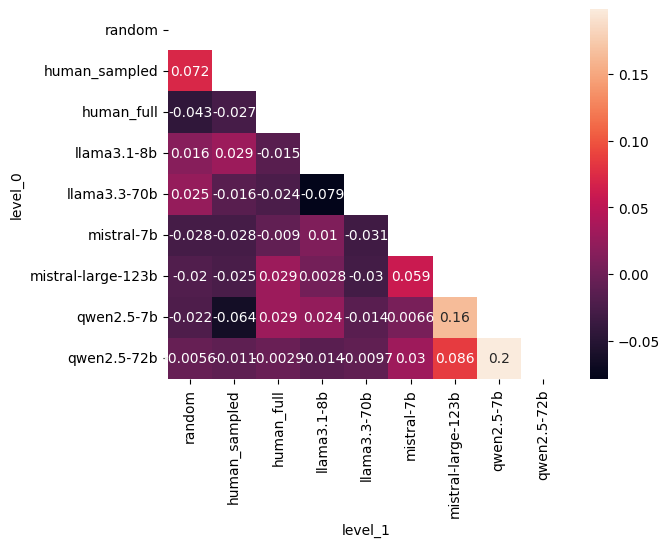

In [23]:
seaborn.heatmap(sim, annot=True, mask=numpy.triu(sim))

In [24]:
human_chunked = {
    f"{n:02d}": chunk
    for n, chunk in enumerate(numpy.array_split(raw["human_full"].sample(frac=1.0), 100), start=1)
}

sim = (
    llmq.evaluation.apply_calc_similarity(human_chunked)
    .to_frame()
    .reset_index(level=[0,1])
    .pivot_table(values="similarity", index="level_0", columns="level_1")
    #
    .where(lambda df: pandas.DataFrame(
        [[i > j for j in range(len(df.columns))] for i in range(len(df.index))],
        index=df.index,
        columns=df.columns
    ))
    
)
sim

print(sim.pipe(llmq.evaluation.format_latex_df))
print({
    "mean": sim.stack().mean(),
    "std": sim.stack().std()
})

/home/ubuntu/repositories/LLM-Questionnaires/.venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


\begin{tabular}{lrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrr}
\toprule
level_1 & \rotatebox{65}{01} & \rotatebox{65}{02} & \rotatebox{65}{03} & \rotatebox{65}{04} & \rotatebox{65}{05} & \rotatebox{65}{06} & \rotatebox{65}{07} & \rotatebox{65}{08} & \rotatebox{65}{09} & \rotatebox{65}{10} & \rotatebox{65}{100} & \rotatebox{65}{11} & \rotatebox{65}{12} & \rotatebox{65}{13} & \rotatebox{65}{14} & \rotatebox{65}{15} & \rotatebox{65}{16} & \rotatebox{65}{17} & \rotatebox{65}{18} & \rotatebox{65}{19} & \rotatebox{65}{20} & \rotatebox{65}{21} & \rotatebox{65}{22} & \rotatebox{65}{23} & \rotatebox{65}{24} & \rotatebox{65}{25} & \rotatebox{65}{26} & \rotatebox{65}{27} & \rotatebox{65}{28} & \rotatebox{65}{29} & \rotatebox{65}{30} & \rotatebox{65}{31} & \rotatebox{65}{32} & \rotatebox{65}{33} & \rotatebox{65}{34} & \rotatebox{65}{35} & \rotatebox{65}{36} & \rotatebox{65}{37} & \rotatebox{65}{38} & \rotatebox{65}{39} & \rotatebox{65}{40} & 

<Axes: xlabel='level_1', ylabel='level_0'>

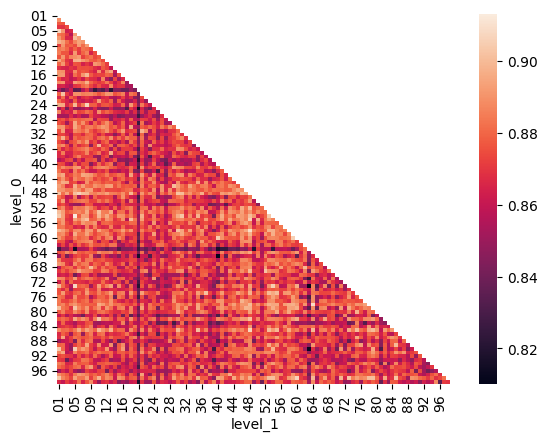

In [25]:
seaborn.heatmap(sim, annot=False, mask=numpy.triu(sim))